In [158]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import stats

In [159]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [160]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

In [161]:
df = pd.read_csv(PATH +'rus_merged_psychosocial_data.csv', index_col=0)
df = df[df.index.notnull()]

In [162]:
df.columns

Index(['age', 'dep.scale', 'dep.severity-1', 'group.code', 'diagnosis.group',
       'diagnosis.type', 'diagnosis_code', 'diagnosis_eng', 'diagnosis_rus',
       'education.level.code', 'education.level.eng', 'education.years',
       'exacerbation', 'HDRS-17.score-1', 'longitudinal', 'panss-1-td',
       'panss-1-total', 'panss-n-1-total', 'panss-o-1-total',
       'panss-p-1-total', 'rehospitalization', 'sans-1-total',
       'saps-ftd-1-total', 'sex', 'sops-1-total', 'sops-c-total',
       'sops-d-total', 'sops-n-total', 'sops-p-total', 'td.scales',
       'td.severity'],
      dtype='object')

In [163]:
res_df = pd.read_csv(PATH + 'processed_values/ru_both.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [164]:
dfi = [i.replace('-', '').replace('S', 'PD1') for i in df.index]
df.index = dfi
# res_df.index = [i.replace('S', 'PD1') for i in res_df.index]
rdfi = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]

missing_psy = set(rdfi).difference(set(dfi))
missing_psy

{'PD104',
 'PD128',
 'PD151',
 'PD152',
 'PD153',
 'PD155',
 'PD156',
 'PD157',
 'PN005',
 'PN006',
 'PN012',
 'PN014',
 'PN019',
 'PN238',
 'PN327'}

In [165]:
set(dfi).issubset(set(rdfi))

True

In [166]:
missing_psy = [i for i in res_df.index if i.split('_')[0] in missing_psy]
res_df.drop(missing_psy, inplace=True)

In [169]:
dataframes = pd.read_excel('/Users/galina.ryazanskaya/Downloads/thesis?/2023_annotation/combined_scales_2023_annotation.xlsx', sheet_name=None)

In [172]:
dataframes['demography'].index

RangeIndex(start=0, stop=132, step=1)

In [110]:
idx = {}
for i in res_df.index:
    idx.setdefault(i.split('_')[0], []).append(i) 
    
for i, v in idx.items():
    if len(v) == 1 and v[0].split('_')[-1] != '1':
        print(i, v, 'non-start-timepoint')
    if len(v) > 1:
        print(i, v)

S01 ['S01_1', 'S01_2', 'S01_3']
S02 ['S02_1', 'S02_2', 'S02_3']
S03 ['S03_1', 'S03_2']
S04 ['S04_1', 'S04_2']
S05 ['S05_1', 'S05_2', 'S05_3']
S06 ['S06_1', 'S06_2']
S08 ['S08_1', 'S08_2', 'S08_3']
S09 ['S09_1', 'S09_2', 'S09_3']
S10 ['S10_1', 'S10_2', 'S10_3']
S11 ['S11_1', 'S11_2', 'S11_3']
S12 ['S12_1', 'S12_2', 'S12_3']
S13 ['S13_1', 'S13_2']
S14 ['S14_1', 'S14_2', 'S14_3']
S15 ['S15_1', 'S15_2']
S16 ['S16_1', 'S16_2', 'S16_3']
S17 ['S17_1', 'S17_3']
S18 ['S18_1', 'S18_3']
S19 ['S19_1', 'S19_2', 'S19_3']
S20 ['S20_1', 'S20_2', 'S20_3']
S21 ['S21_1', 'S21_2']
S22 ['S22_1', 'S22_3']
S23 ['S23_1', 'S23_2']
S24 ['S24_1', 'S24_2', 'S24_3']
S25 ['S25_1', 'S25_2']
S27 ['S27_1', 'S27_2', 'S27_3']
S29 ['S29_1', 'S29_2']
S31 ['S31_1', 'S31_2']
S33 ['S33_1', 'S33_2']
S34 ['S34_1', 'S34_2']
S35 ['S35_1', 'S35_2']
S36 ['S36_1', 'S36_2']
S37 ['S37_1', 'S37_2']
S38 ['S38_1', 'S38_2']
S39 ['S39_1', 'S39_2']
S40 ['S40_1', 'S40_2']
S41 ['S41_1', 'S41_2']
S42 ['S42_1', 'S42_2']
S43 ['S43_1', 'S43_2']


In [111]:
non_start_timepoint = [i for i in res_df.index if i.split('_')[-1] != '1']
res_df.drop(non_start_timepoint, inplace=True)

In [142]:
idx = {}
for i in res_df.index:
    idx.setdefault(i.split('_')[0], []).append(i) 
    
for i, v in idx.items():
    if len(v) == 1 and v[0].split('_')[-1] != '1':
        print(i, v, 'non-start-timepoint')
    if len(v) > 1:
        print(i, v)

In [121]:
res_df.loc['PD101_1'].dropna()

TASK                               
adventure  LM         m_bert_cgcoh      0.954746
                      m_bert_gcoh       0.942201
                      m_bert_lcoh       0.873049
                      m_bert_scoh       0.865214
                      m_cgcoh           0.930773
                                         ...    
sportsman  syntactic  max_sent_len     20.000000
                      mean_sent_len     8.500000
                      min_sent_len      2.000000
                      n_sents          12.000000
                      std_sent_len      4.425306
Name: PD101_1, Length: 156, dtype: float64

In [120]:
res_df.loc['S01_1'].dropna()

TASK                               
chair      LM         m_bert_cgcoh      0.961930
                      m_bert_gcoh       0.955538
                      m_bert_lcoh       0.902659
                      m_bert_scoh       0.904813
                      m_cgcoh           0.903503
                                         ...    
winterday  syntactic  max_sent_len     11.000000
                      mean_sent_len     5.228571
                      min_sent_len      2.000000
                      n_sents          35.000000
                      std_sent_len      2.178934
Name: S01_1, Length: 113, dtype: float64

In [122]:
res_df.loc['PD103_1'].dropna()

TASK                                 
adventure  LM         m_bert_cgcoh         0.965943
                      m_bert_gcoh          0.962893
                      m_bert_lcoh          0.916924
                      m_bert_scoh          0.928329
                      m_cgcoh              0.985643
                      m_gcoh               0.984355
                      m_lcoh               0.965453
                      m_scoh               0.963595
                      m_sporb              0.981868
           graph      L1                   0.000000
                      L2                   1.507692
                      L3                  28.384615
                      LCC                 59.707692
                      LSC                 58.015385
                      PE                   7.753846
                      degree_average       3.318450
                      degree_std           3.133626
                      number_of_edges     99.000000
                      numb

In [123]:
res_df.loc['S03_1'].dropna()

TASK                               
present    LM         m_bert_cgcoh      0.976053
                      m_bert_gcoh       0.961533
                      m_bert_lcoh       0.908713
                      m_bert_scoh       0.933705
                      m_cgcoh           0.999952
                                         ...    
winterday  syntactic  max_sent_len      9.000000
                      mean_sent_len     4.653846
                      min_sent_len      2.000000
                      n_sents          26.000000
                      std_sent_len      2.129325
Name: S03_1, Length: 115, dtype: float64

In [124]:
res_df.loc['PD102_1'].dropna()

TASK                               
adventure  LM         m_bert_cgcoh      0.983063
                      m_bert_gcoh       0.977067
                      m_bert_lcoh       0.956447
                      m_bert_scoh       0.948733
                      m_cgcoh           0.847485
                                         ...    
sportsman  syntactic  max_sent_len     16.000000
                      mean_sent_len     9.100000
                      min_sent_len      3.000000
                      n_sents          10.000000
                      std_sent_len      4.369210
Name: PD102_1, Length: 150, dtype: float64

In [125]:
res_df.loc['S02_1'].dropna()

TASK                               
adventure  LM         m_bert_cgcoh     0.969722
                      m_bert_gcoh      0.967034
                      m_bert_lcoh      0.925048
                      m_bert_scoh      0.935385
                      m_cgcoh          0.994149
                                         ...   
present    syntactic  max_sent_len     9.000000
                      mean_sent_len    6.000000
                      min_sent_len     3.000000
                      n_sents          2.000000
                      std_sent_len     3.000000
Name: S02_1, Length: 108, dtype: float64

In [136]:
raw = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/rus_transcript_lex_by_task_with_dots.tsv', sep='\t', index_col=0)

In [137]:
raw.loc['S02_1'].dropna()

adventure    Мама оставила ребенка в коляске. И пошла в маг...
chair        Первое действие. Положите столешницу стула на ...
present      Надо нуу. Двее замечательные дочери самый лучш...
Name: S02_1, dtype: object

In [138]:
raw.loc['PD102_1'].dropna()

adventure    Первое это. В коляске малыш. Его везет бабушка...
chair        Ну прикрутить ну. Ножку к стулу. Прикрутить но...
present      Ну последнее мне подарили поездку в деревню. В...
sportsman    Ну тузет значит полный человек и худой. Худой ...
Name: PD102_1, dtype: object

In [140]:
raw.loc['S03_1'].dropna()

present      Ну какие. Зять внучка на день рождения и на но...
table        На его пару ножек ставим. Крепим этими. Как ег...
winterday    Мальчик посмотрел в окно. Зим. Пошел гулять. И...
Name: S03_1, dtype: object

In [141]:
raw.loc['PD103_1'].dropna()

adventure    Ребенок сидит в коляке. К нему подходит какой-...
Name: PD103_1, dtype: object

In [188]:
raw.isna().sum(axis=0).sum()

1806

<AxesSubplot: >

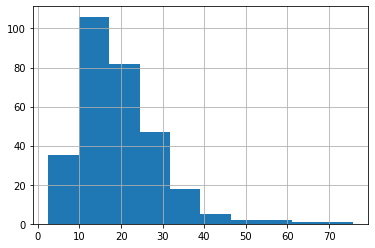

In [218]:
raw.applymap(lambda x: len(x.split('.')) if not pd.isna(x) else np.nan).mean(axis=1).hist()

In [200]:
( 855 * 20 ) / 30

570.0

In [239]:
n = 200
total = 0
total_len = min(n//5, 40)
for x in range(2, total_len):
    total += (n // x) * x

In [240]:
total

7288

In [228]:
total / 500

14.576

In [229]:
48 * 60 / 15

192.0

In [226]:
robust_total / 500

0.0

In [153]:
for i in res_df.index:
    if i.startswith('S') and i.replace('S', 'PD1') in res_df.index:
        res_i = raw.loc[i]
        res_pdi = raw.loc[i.replace('S', 'PD1')]
#         print(i, i.replace('S', 'PD1'))
        print(i, ', '.join(res_i.dropna().index))
        print(i.replace('S', 'PD1'), ', '.join(res_pdi.dropna().index))
#         print()

S01_1 chair, present, winterday
PD101_1 adventure, chair, present, sportsman
S02_1 adventure, chair, present
PD102_1 adventure, chair, present, sportsman
S03_1 present, table, winterday
PD103_1 adventure
S05_1 chair, present, sportsman
PD105_1 adventure
S06_1 bench, present, winterday
PD106_1 adventure, chair, present, sportsman
S07_1 chair, sportsman, trip
PD107_1 adventure, chair, present, sportsman
S08_1 present, table, winterday
PD108_1 adventure
S09_1 adventure, chair, present
PD109_1 adventure, sportsman
S10_1 bench, present, sportsman
PD110_1 adventure, chair, present, sportsman
S11_1 bench, party, winterday
PD111_1 adventure, chair, present, sportsman
S12_1 adventure, chair, party
PD112_1 adventure, chair, present, sportsman
S13_1 adventure, chair, trip
PD113_1 adventure, chair, present, sportsman
S14_1 chair, trip, winterday
PD114_1 adventure, sportsman
S15_1 sportsman, table, trip
PD115_1 adventure, chair, present, sportsman
S16_1 chair, trip, winterday
PD116_1 adventure, cha